In [1]:
import os
import optuna
from optuna.storages import JournalFileStorage, JournalStorage
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def extract_scalar_arrays(scalar_events):
    wall_times = []
    steps = []
    values = []

    for event in scalar_events:
        wall_times.append(event.wall_time)
        steps.append(event.step)
        values.append(event.value)

    return np.array(wall_times), np.array(steps), np.array(values)

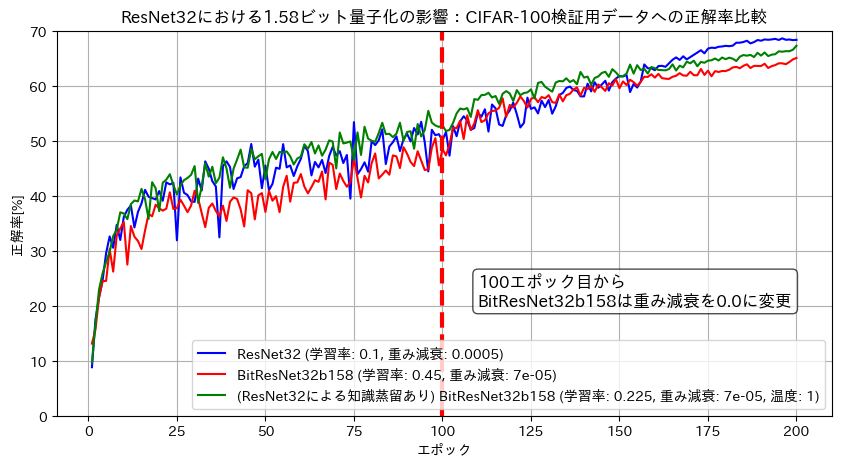

In [3]:
import matplotlib.pyplot as plt
import japanize_matplotlib
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# ハイパーパラメータの設定
hyperparameters = {
    "ResNet32": {
        "color": "blue",
        "linestyle": "-",
        "label": "ResNet32",
        "learning_rate": 0.1,
        "wd": 5e-4,
        "T": None,
    },
    "Bit_ResNet32_b158": {
        "color": "red",
        "linestyle": "-",
        "label": "BitResNet32b158",
        "learning_rate": 0.45,
        "wd": 7e-05,
        "T": None,
    },
    "KDBitResNet32b158(教師モデル: ResNet32)": {
        "color": "green",
        "linestyle": "-",
        "label": "(ResNet32による知識蒸留あり) BitResNet32b158",
        "learning_rate": 0.45 / 2,
        "wd": 7e-05,
        "T": 1,
    },
}

plt.figure(figsize=(10, 5))

for model, params in hyperparameters.items():
    if "KDBitResNet32b158" in model:
        accumulator = EventAccumulator(f"runs/bit_kd_2/0000/0_bit_resnet32_b158/")
    else:
        accumulator = EventAccumulator(f"runs/pre-train/{model.lower()}/")
    accumulator.Reload()
    wall_times, steps, values = extract_scalar_arrays(accumulator.Scalars("test_top1"))

    plt.plot(
        steps,
        values,
        label=(
            f"{params['label']} (学習率: {params['learning_rate']}, 重み減衰: {params['wd']}, 温度: {params['T']})"
            if params["T"] is not None
            else f"{params['label']} (学習率: {params['learning_rate']}, 重み減衰: {params['wd']})"
        ),
        color=params["color"],
        linestyle=params["linestyle"],
    )

# タイトルや軸ラベルを設定
plt.title("ResNet32における1.58ビット量子化の影響：CIFAR-100検証用データへの正解率比較")
plt.xlabel("エポック")
plt.ylabel("正解率[%]")
plt.ylim(0, 70)

# 凡例を表示
plt.legend()

# グリッドを表示
plt.grid(True)

plt.axvline(x=100, color="red", linestyle="--", linewidth=3)
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1, alpha=0.7)
plt.text(
    110,
    20,
    "100エポック目から\nBitResNet32b158は重み減衰を0.0に変更",
    fontsize=12,
    color="black",
    bbox=bbox_props,
)

# グラフを保存して表示
plt.savefig("val-top1-plot.svg", format="svg", bbox_inches="tight")
plt.show()